# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

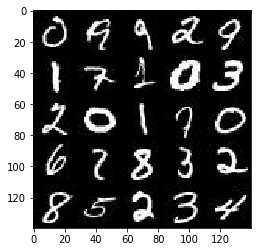

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

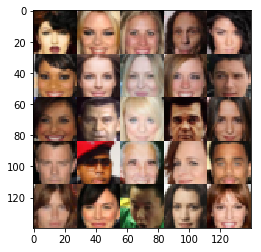

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x128
        
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    z_dim = tf.shape(z)
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        #x1 = tf.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, filters=64, kernel_size=5, strides=2, padding='same')
        #x2 = tf.batch_normalization(x1, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x64
        
        logits = tf.layers.conv2d_transpose(x2, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        #28x28xout_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    import pickle as pkl
    
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    n_images = 4
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 0.5222... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 1.9416
Epoch 1/2... Discriminator Loss: 0.4255... Generator Loss: 1.6073
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 0.5253... Generator Loss: 1.5958


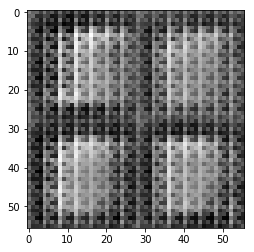

Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.2770... Generator Loss: 2.1720
Epoch 1/2... Discriminator Loss: 0.4510... Generator Loss: 1.8351
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 2.4313
Epoch 1/2... Discriminator Loss: 0.4825... Generator Loss: 1.4986
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 2.3921
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 2.6506
Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 0.4202... Generator Loss: 2.9433


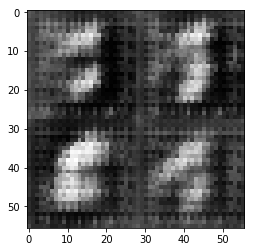

Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 1.6428
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 1.9229
Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 1.6125
Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 1.9450
Epoch 1/2... Discriminator Loss: 0.4764... Generator Loss: 2.7771
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.3228
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 0.6494... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 0.9151


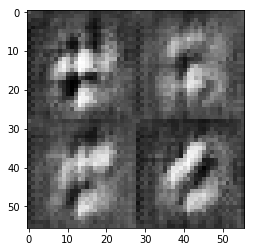

Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 3.0839
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 1.3896
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 1.1391


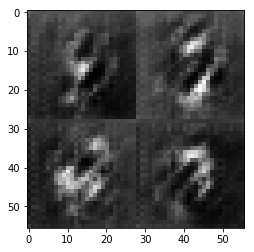

Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.8481
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.3902
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.6003
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.5685
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 1.2551


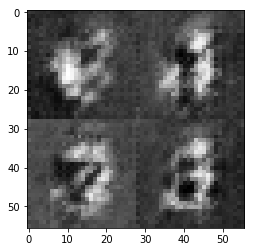

Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.8813
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.6075
Epoch 1/2... Discriminator Loss: 0.9082... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 0.9604
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 2.4357
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 0.8520


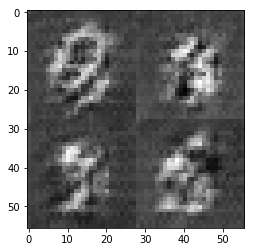

Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.2293
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 1.6834
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 1.2605
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 0.6459... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.6878
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.4911
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.3696


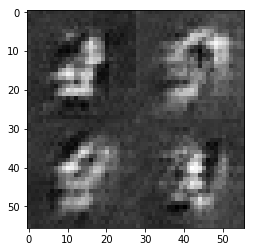

Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 0.6845... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 0.5466... Generator Loss: 1.5025
Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 1.2576
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.0480


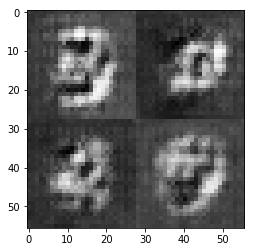

Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 0.6208... Generator Loss: 2.0409
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 1.2102
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 2.6951
Epoch 1/2... Discriminator Loss: 0.4275... Generator Loss: 1.5344
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 1.4271
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 1.4856


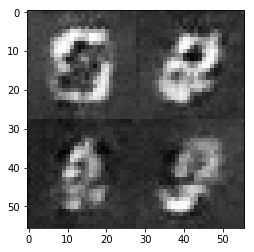

Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 1.4521
Epoch 1/2... Discriminator Loss: 0.6061... Generator Loss: 1.8260
Epoch 1/2... Discriminator Loss: 0.4797... Generator Loss: 2.2993
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 2.2580
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.0719
Epoch 1/2... Discriminator Loss: 0.4938... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 0.5291... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 0.8650


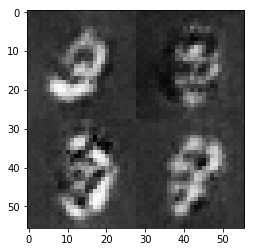

Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 1.8600
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 1.3554
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 2.0404
Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 2.3897
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 0.6287... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.4273


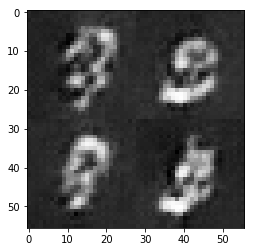

Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 1.6871
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 2.2651
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 1.3920
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 0.4822... Generator Loss: 1.4557
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.9146
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.9455
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 1.6657
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 0.9234


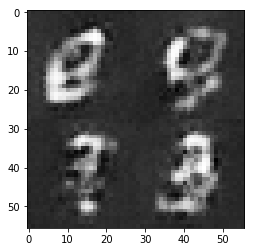

Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 2.4275
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 1.6743
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 1.3929
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 2.0467
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.4197


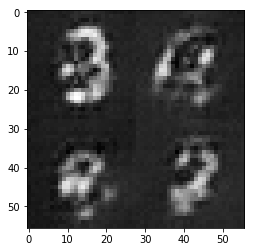

Epoch 1/2... Discriminator Loss: 0.5156... Generator Loss: 1.7098
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 1.7596
Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 0.3787... Generator Loss: 2.0610
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 2.4159
Epoch 1/2... Discriminator Loss: 0.5985... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.5628
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 2.1968
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.6400


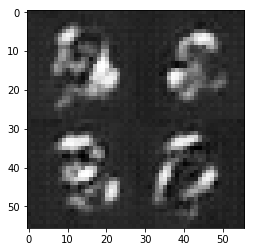

Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 1.0996
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.2414
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 0.5943... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.4908
Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.5664


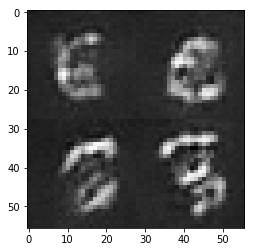

Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.9374
Epoch 1/2... Discriminator Loss: 0.6123... Generator Loss: 1.1094
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.4184
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 2.0001
Epoch 1/2... Discriminator Loss: 0.6011... Generator Loss: 1.4528
Epoch 1/2... Discriminator Loss: 0.4879... Generator Loss: 1.8193
Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.2287
Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 1.4215
Epoch 1/2... Discriminator Loss: 0.6572... Generator Loss: 1.3207


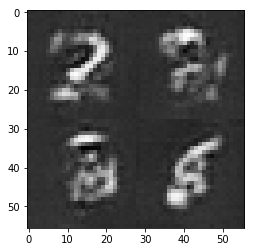

Epoch 1/2... Discriminator Loss: 0.5578... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.3540
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 1.7866
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.0900
Epoch 1/2... Discriminator Loss: 0.4767... Generator Loss: 1.6433
Epoch 1/2... Discriminator Loss: 0.6069... Generator Loss: 1.1862
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.9482
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 1.9915
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.1059


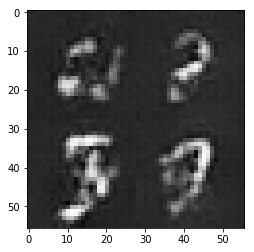

Epoch 1/2... Discriminator Loss: 0.6011... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.0694
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 1.6990
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 1.6870
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 2.0619
Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 1.3624
Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 1.8309
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 1.4049
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.7003


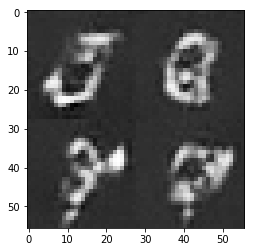

Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 1.8880
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 0.3176... Generator Loss: 2.1492
Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 1.2211
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 0.6231... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 0.5647... Generator Loss: 2.0784
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.4677
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 0.6106


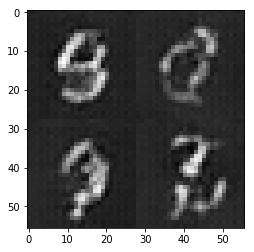

Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.4065
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 0.9495
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 2.4501
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 2.0958
Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 0.4995... Generator Loss: 1.8734
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 1.4760


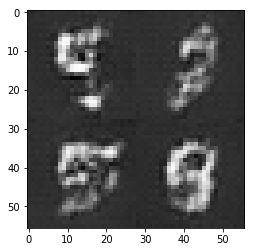

Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 1.7411
Epoch 1/2... Discriminator Loss: 0.5693... Generator Loss: 1.3046
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 1.3569
Epoch 1/2... Discriminator Loss: 0.5842... Generator Loss: 1.4719
Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 2.4948


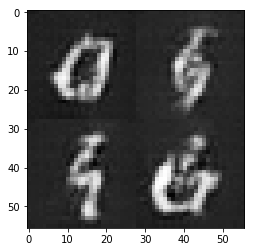

Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 1.6987
Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.3975
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.7908
Epoch 1/2... Discriminator Loss: 0.6617... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 0.3826... Generator Loss: 1.3200


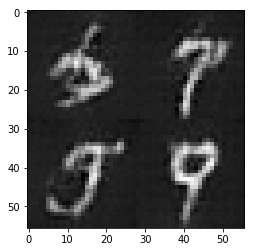

Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.0103
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 1.3336
Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 2.3021
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.7205
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 1.7411
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 1.9570
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 2.5035


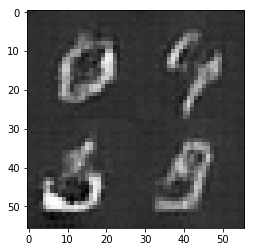

Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.2637
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 2.0436
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 1.2965
Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.5063
Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 1.0056


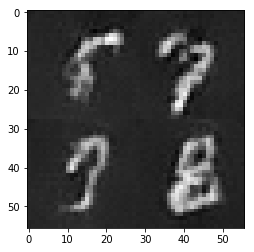

Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 2.3279
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 1.4946
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.3985
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.4575


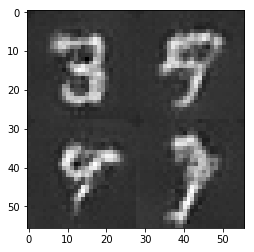

Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 2.0388
Epoch 1/2... Discriminator Loss: 0.5000... Generator Loss: 1.8372
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 1.3647
Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.7729... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 2.6550
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 1.4815


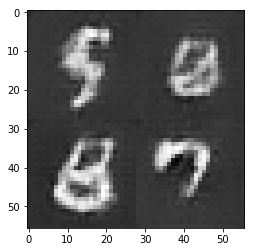

Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 2.2729
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.2669
Epoch 1/2... Discriminator Loss: 0.8857... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 0.4788... Generator Loss: 2.4700
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 0.6801... Generator Loss: 0.9989
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 1.0026
Epoch 1/2... Discriminator Loss: 0.5482... Generator Loss: 1.2123
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.9938


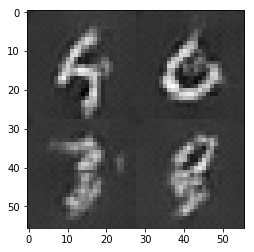

Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 1.6869
Epoch 1/2... Discriminator Loss: 0.6350... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 1.5281
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 1.4276
Epoch 1/2... Discriminator Loss: 0.8324... Generator Loss: 1.7226
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 0.8245


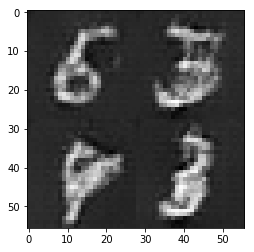

Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.2308
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 2.4842
Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 1.5045


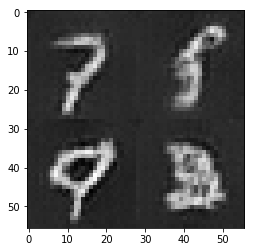

Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.4935
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.4054
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.5230
Epoch 1/2... Discriminator Loss: 0.4916... Generator Loss: 1.5856
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 0.5822... Generator Loss: 1.2169
Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.2190
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 1.5310
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 2.3952


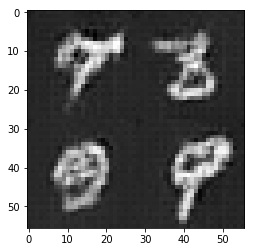

Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.5658
Epoch 1/2... Discriminator Loss: 0.6982... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.7307
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.6088


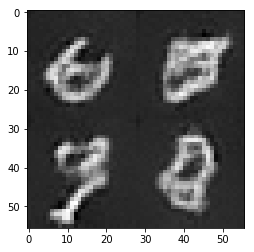

Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.2605
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.1976
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 1.5737
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.3360
Epoch 1/2... Discriminator Loss: 0.5650... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.4302


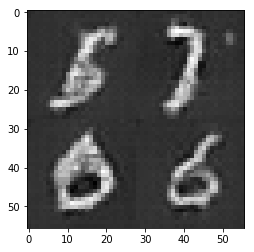

Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.6192
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 2.2045
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 1.6103
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 1.5112
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 1.4273
Epoch 1/2... Discriminator Loss: 0.5091... Generator Loss: 2.1304


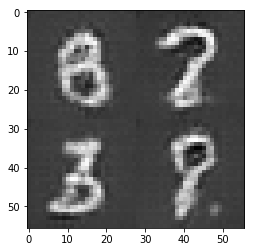

Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 0.6708... Generator Loss: 2.6046
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 2.0623
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 0.6969... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.6758


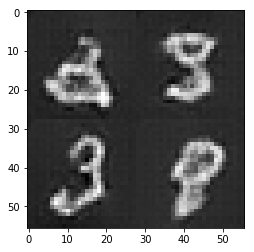

Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 1.3543
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 1.3489
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.4512
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 1.3700
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.7626


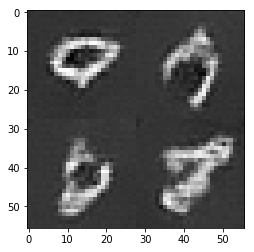

Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 1.4309
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.3655
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.7239
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 1.1675
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 0.8707
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.4855


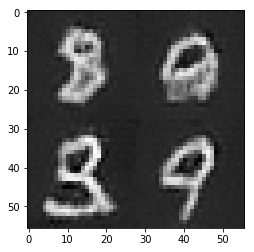

Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.1299
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 1.4648


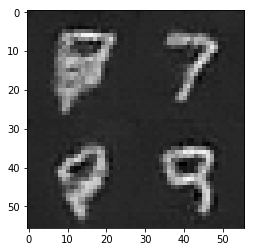

Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 0.9005
Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.4294
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.1898


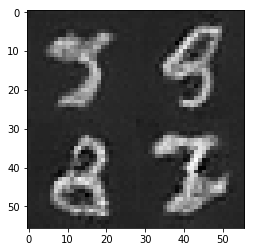

Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.3888
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.4767
Epoch 1/2... Discriminator Loss: 0.8368... Generator Loss: 0.8953
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 1.6131


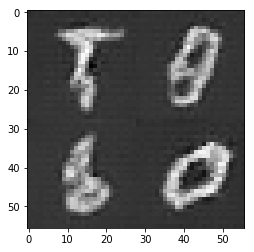

Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 1.9255
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 2.7131
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 1.5752
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 0.7001


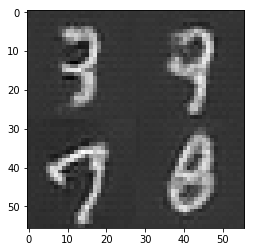

Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.6891
Epoch 1/2... Discriminator Loss: 0.6542... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 0.4495... Generator Loss: 1.3701
Epoch 1/2... Discriminator Loss: 0.8026... Generator Loss: 1.2664
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.8548
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 0.7730... Generator Loss: 0.9772


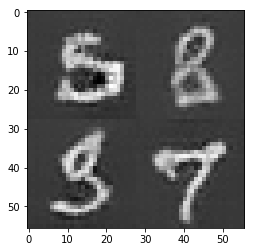

Epoch 1/2... Discriminator Loss: 0.6078... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.9107
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.3509
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 0.6489


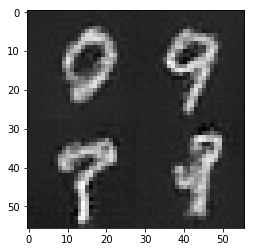

Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 1.3763
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 1.7852
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.7625


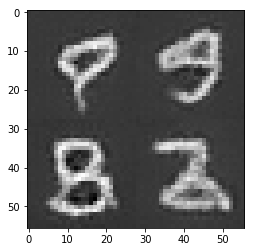

Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.5806
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 1.6770
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.8320


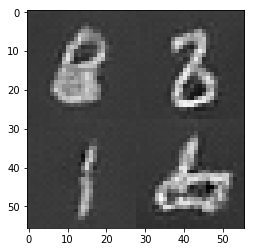

Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.2458
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 1.6142
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 1.9903
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 2.0567
Epoch 1/2... Discriminator Loss: 0.9571... Generator Loss: 0.7863
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.7096


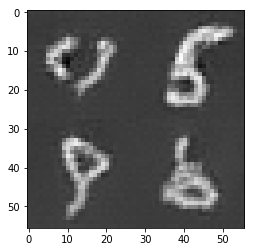

Epoch 1/2... Discriminator Loss: 0.9879... Generator Loss: 1.3583
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.8121
Epoch 1/2... Discriminator Loss: 0.6992... Generator Loss: 1.4498
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.5723
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.0215


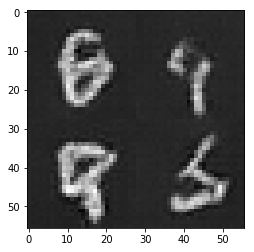

Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 0.5363... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.0662
Epoch 1/2... Discriminator Loss: 0.6816... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 0.6188
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.0176
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.2743


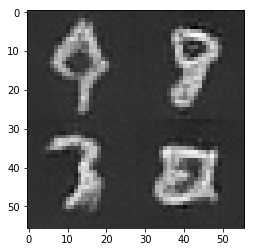

Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 0.6745... Generator Loss: 1.5168
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.2748
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.5702... Generator Loss: 2.0071
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.3081


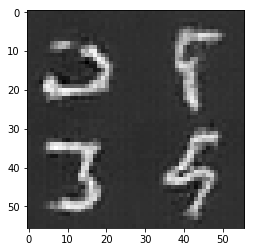

Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 1.9917
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.4827
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.2945
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 1.3855


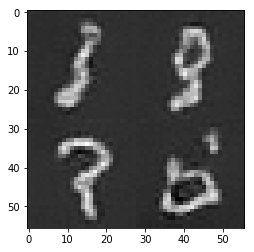

Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.4621
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 0.8479
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 0.8826
Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.1836
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 0.5604... Generator Loss: 1.4805


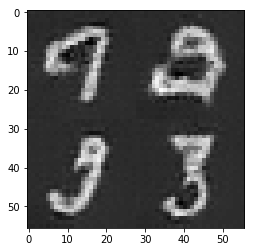

Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 0.6073... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.6876
Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 1.7138
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 1.2951


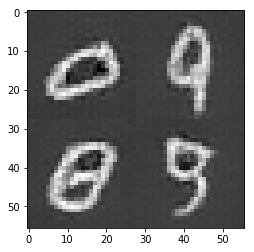

Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.3603
Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.4514
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.6607... Generator Loss: 0.2447
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.5838


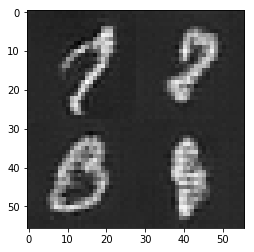

Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 0.7825... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 0.7818... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.1488
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.3176
Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 2.0305


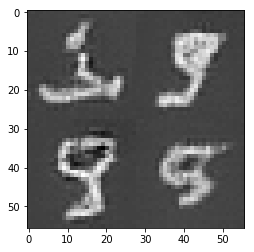

Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.0148
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.5126
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.4300


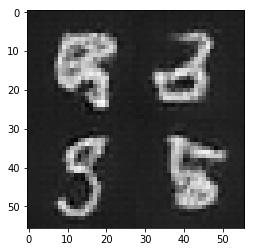

Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 0.7302... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.4869


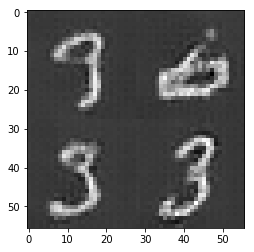

Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 1.5473
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.5742
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.4839
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.3816
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.8966
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.4888


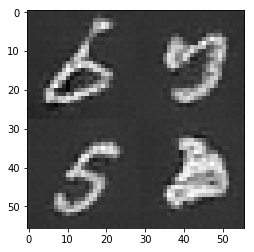

Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 0.6338... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 0.5513... Generator Loss: 1.6316


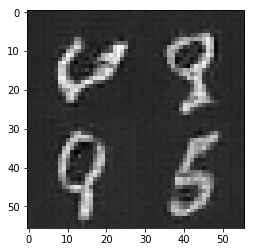

Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.5060
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 0.7893... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.9638


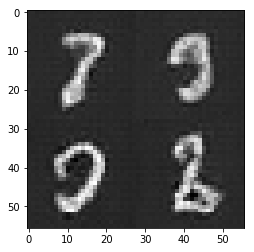

Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 1.2853
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.3376
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.5090
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.0059
Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.5686


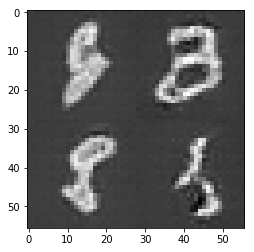

Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 1.0250
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 1.7191
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.0277
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 0.8274... Generator Loss: 1.3546
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.2693
Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 1.3224


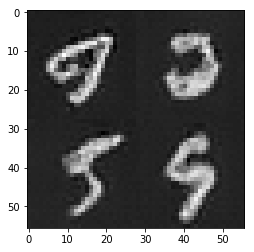

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.4324
Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.8216
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 0.8407


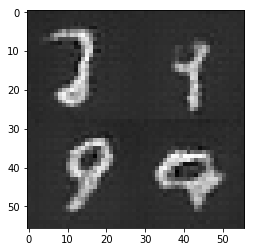

Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.4358
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.1565
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.6436
Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 1.0543
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.0323


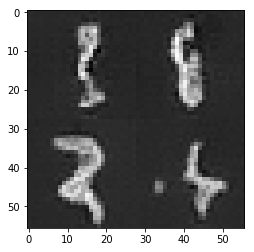

Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 1.4514
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.3796
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.3871
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.8971
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 0.8984
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.1714


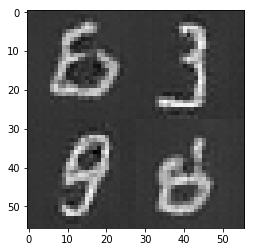

Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.6017
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 1.0203
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.0980
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.5190
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 0.7806


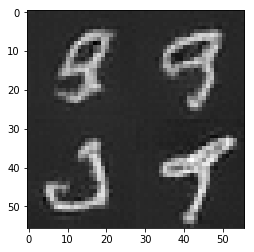

Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.6056
Epoch 2/2... Discriminator Loss: 0.9257... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 2.1625


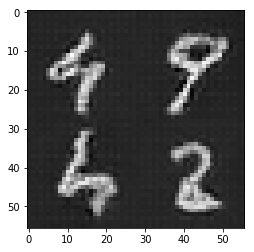

Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 1.7782
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 2.4309
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.5158
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.7702
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.0476
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.6511


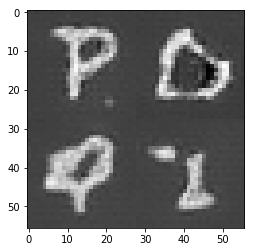

Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 1.5650
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 2.0013
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 0.9426
Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.5806
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.2041


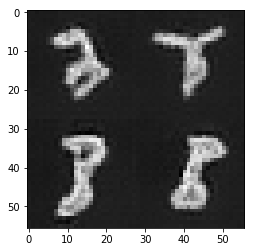

Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 0.7472... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 1.1162
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.0647
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.1429


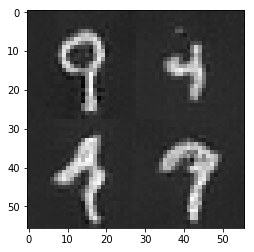

Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 2.0390
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.5642


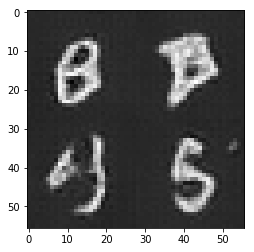

Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 1.3524
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 0.4774... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 0.5695... Generator Loss: 1.4350
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 0.6527


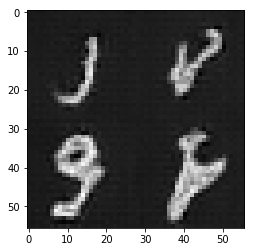

Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.7386
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.9254
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.3072
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 0.7791


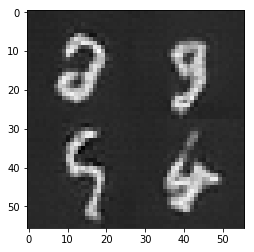

Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 0.6273... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.1640
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.3209
Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 1.5719
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.7512


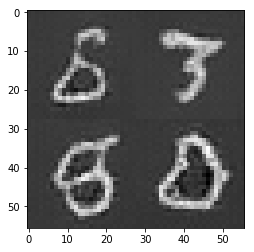

Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.4873
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.3092
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.0230
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 1.4246
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 1.4195
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 1.3002


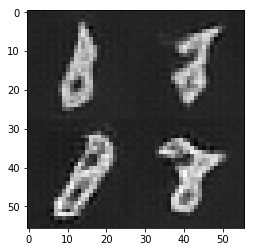

Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 1.8053
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.1125
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.4777
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.2072


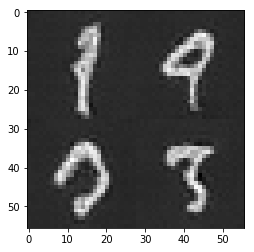

Epoch 2/2... Discriminator Loss: 0.7173... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.0990
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 0.7011... Generator Loss: 1.2800
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 0.7078... Generator Loss: 1.0110
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.1623


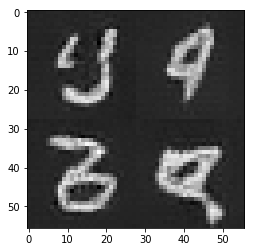

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.9799
Epoch 2/2... Discriminator Loss: 0.6626... Generator Loss: 1.3808
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.9645... Generator Loss: 1.1098
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.6846
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.6288


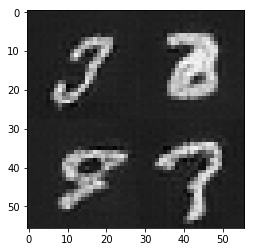

Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.4306
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 1.9811
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.1529
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.4949
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.7013
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.2228


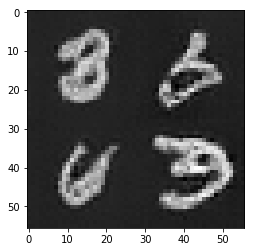

Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.4277
Epoch 2/2... Discriminator Loss: 0.9017... Generator Loss: 1.6022
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.3192
Epoch 2/2... Discriminator Loss: 0.5318... Generator Loss: 1.4781
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 2.2073
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 2.0045
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 1.7491


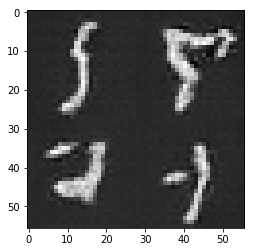

Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 0.8969... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 1.0085


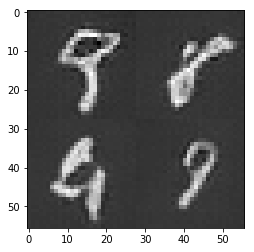

Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 1.2015... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 1.4276
Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 1.8972
Epoch 2/2... Discriminator Loss: 0.6233... Generator Loss: 1.1249
Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.4023
Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.4358
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 0.9816


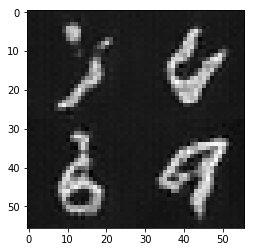

Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 0.9076
Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 0.8352... Generator Loss: 2.0759
Epoch 2/2... Discriminator Loss: 0.5450... Generator Loss: 1.5894
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.4977
Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 1.3389


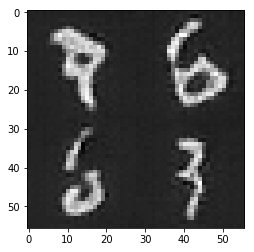

Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 0.8273... Generator Loss: 1.1470
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.4763
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.7021


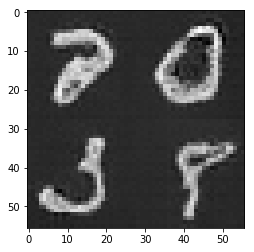

Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 0.7498... Generator Loss: 1.4715
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.5545
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 0.6277... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 0.9767
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.4109


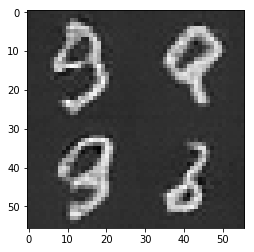

Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.8245
Epoch 2/2... Discriminator Loss: 0.5944... Generator Loss: 1.4007
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.7629
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.5469
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 1.0439
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.5360
Epoch 2/2... Discriminator Loss: 0.5344... Generator Loss: 1.2533


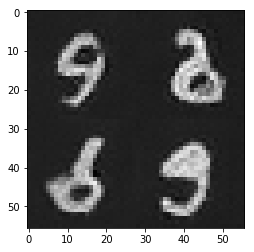

Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 1.1249
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.8577
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.4287
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 2.0708
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 0.9874


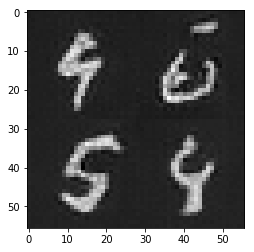

Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.5878
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 2.1770
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 1.2102
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 0.5100... Generator Loss: 1.6807


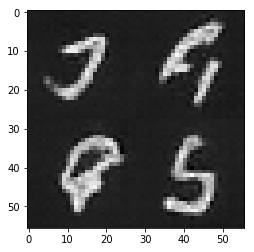

Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.4000
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 1.1179
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.6759
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 0.8159... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.3784
Epoch 2/2... Discriminator Loss: 0.7956... Generator Loss: 1.4281


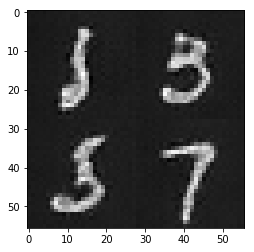

Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 0.9216
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 0.9542


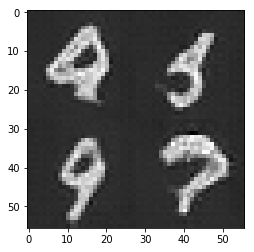

Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 0.6237... Generator Loss: 1.4107
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.4716
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.0331


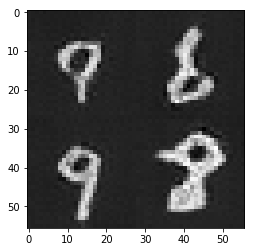

Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 1.6762
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.5132
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.3583
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.1787
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.2793


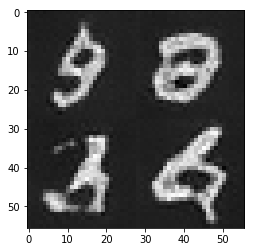

Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.2662
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 1.1436
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 1.5767
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.6301
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.6204


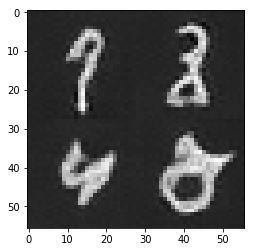

Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.5366
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.4362
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.2985
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.1826
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.9091


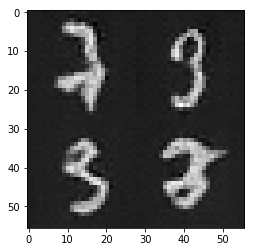

Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.6204
Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.3554


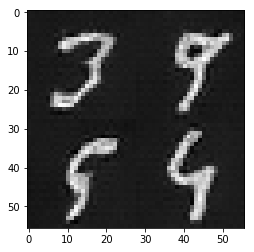

Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.9008
Epoch 2/2... Discriminator Loss: 1.0002... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 1.4773
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 1.0362


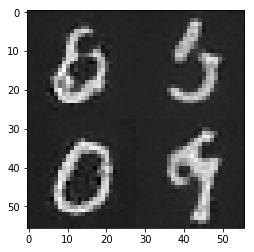

Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 0.5329... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.0546
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 1.7819
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.1009
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.7015


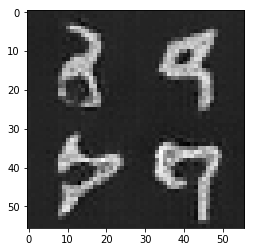

Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.7903
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.9252
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.4414
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.2928
Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 1.0999


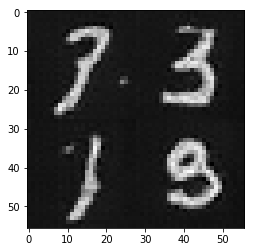

Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.1191
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.5795
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.4482
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.5460
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.2382


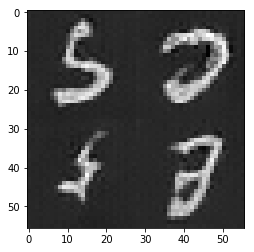

Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.6664
Epoch 2/2... Discriminator Loss: 0.6696... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.0751


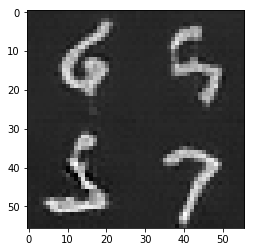

Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 1.6295
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.9265
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 1.2001
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.7471


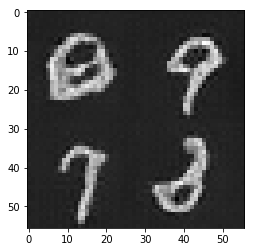

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.7186
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 1.4165
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.4698


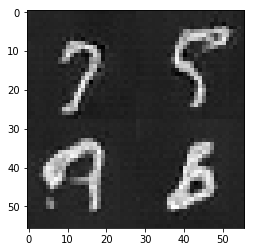

Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 1.5152
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.2591
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.8419
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.0981


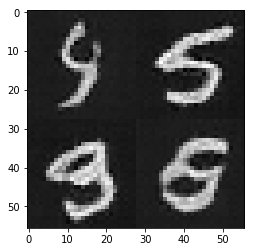

Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 1.5680
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.6816
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.0302


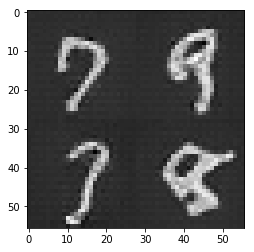

Epoch 2/2... Discriminator Loss: 1.0949... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.2750
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 0.6666... Generator Loss: 1.0147
Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 0.4927... Generator Loss: 1.9971
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.4733
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.1775
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.2537


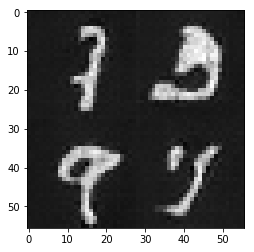

Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.2800
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 1.4741
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.6385


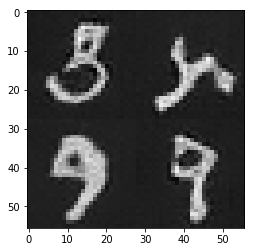

Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 1.5627
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.5779
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.0891
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.1407
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 0.5841... Generator Loss: 2.1938
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 0.7420


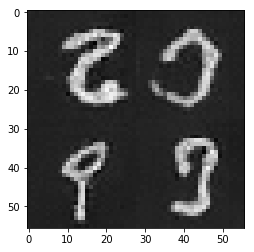

Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.9663
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 0.9961
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.1090
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 1.8496
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 1.1507
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.7269
Epoch 2/2... Discriminator Loss: 0.8392... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.6961
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.3237


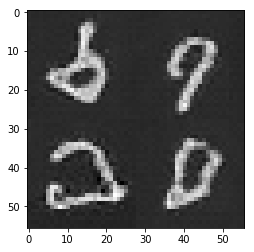

Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 0.9864
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 1.6538
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.1720
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.3848


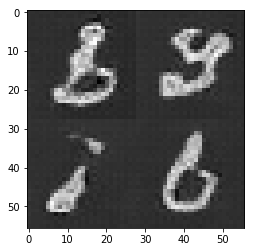

Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.4085
Epoch 2/2... Discriminator Loss: 0.5572... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.2885
Epoch 2/2... Discriminator Loss: 0.8632... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 1.7352
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.9799
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.0766


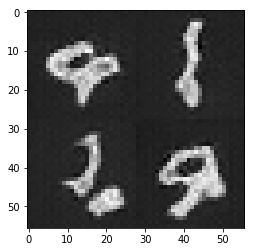

Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.5905
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.5382
Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.9069
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.3307
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 0.9554
Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.7979


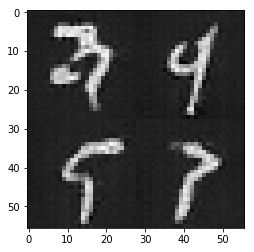

Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.6301
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 1.0604... Generator Loss: 1.0790
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 1.2007
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.3353


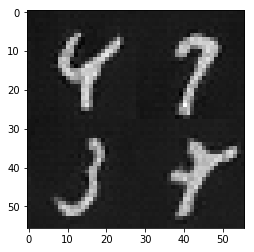

Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.7604
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 0.8737... Generator Loss: 1.2413
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.5319
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 0.8082


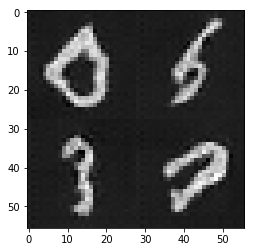

Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.0532
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 1.6561
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.1454
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.5170
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.4303


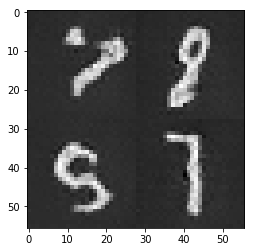

Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.1605
Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.1595


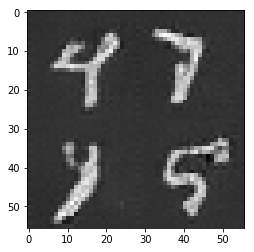

Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.6399
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 0.9897
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 1.3834
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.6471
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.5089


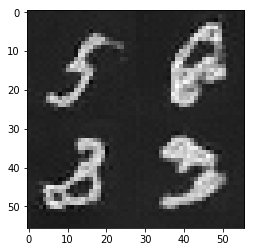

Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 1.4440
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.5208
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.1402
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.1358
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.4690


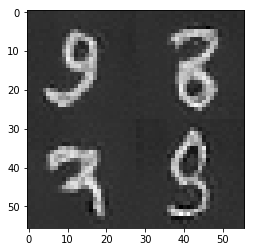

Epoch 2/2... Discriminator Loss: 0.6594... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.3244
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.4843
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 0.8342... Generator Loss: 1.4883
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 1.8481
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.0177


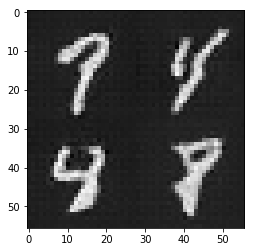

Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 1.2305
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.2152
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 2.0980
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 0.5428... Generator Loss: 1.7228


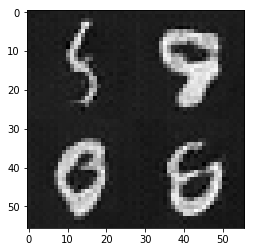

Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.6158
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 0.7603... Generator Loss: 1.1670
Epoch 2/2... Discriminator Loss: 0.7916... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.0791


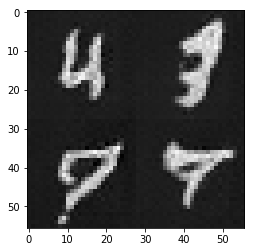

Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 2.0967
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.6335
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 2.1059
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9258


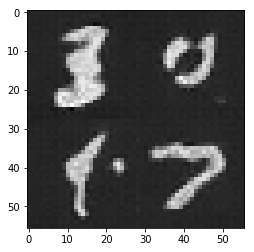

Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.2021
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.5054
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.4182


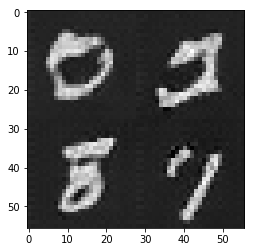

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 1.7531
Epoch 1/1... Discriminator Loss: 0.2542... Generator Loss: 2.1685
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 2.3833... Generator Loss: 0.5777


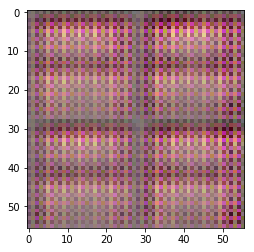

Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 1.9229
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 1.9298
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.0720


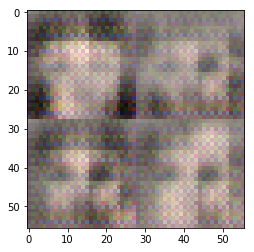

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8915


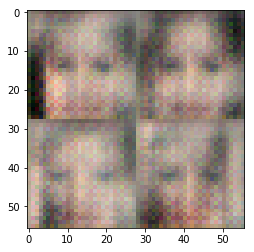

Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7926


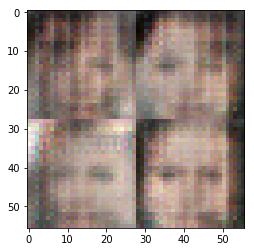

Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.8675


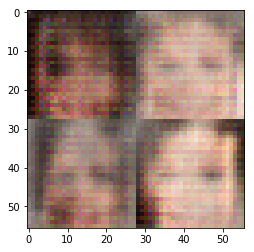

Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7697


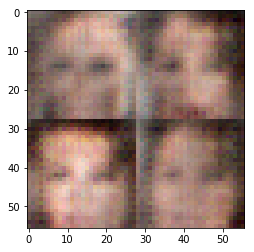

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7225


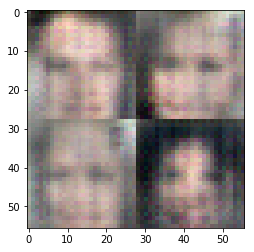

Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8022


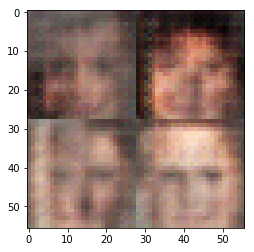

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.7182


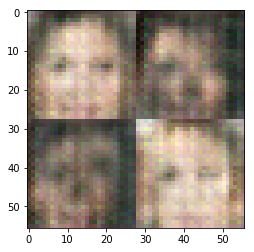

Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.7611


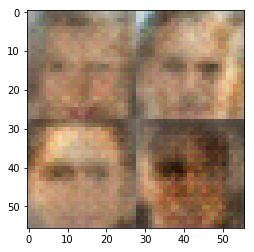

Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7538


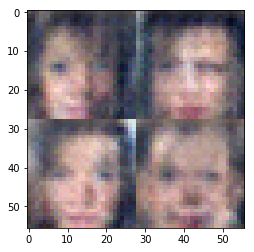

Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6999


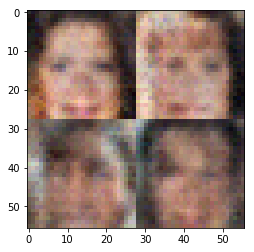

Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6919


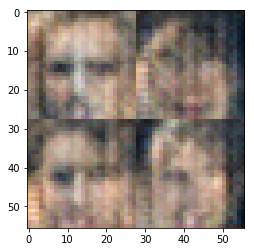

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7790


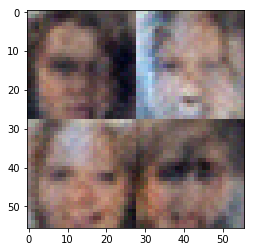

Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8835


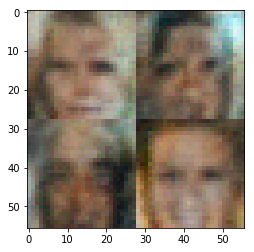

Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6875


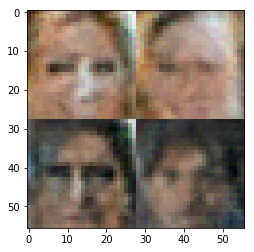

Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7554


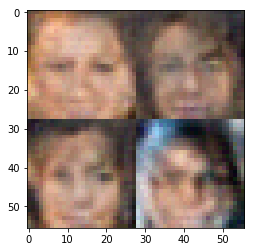

Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6945


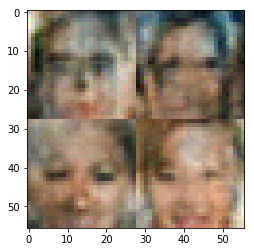

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7767


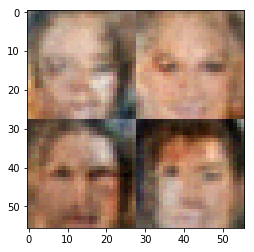

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7205


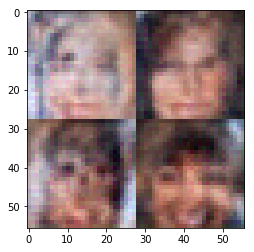

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6848


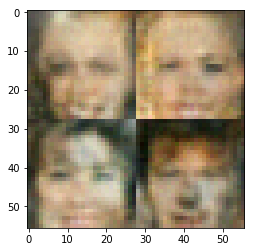

Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8085


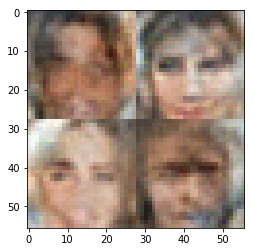

Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7459


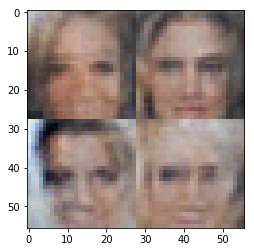

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7198


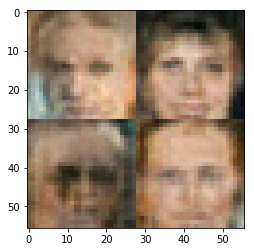

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7580


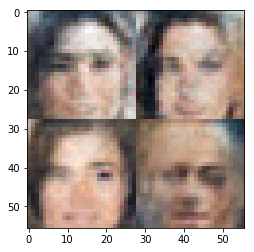

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7464


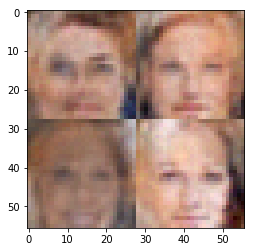

Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.6255


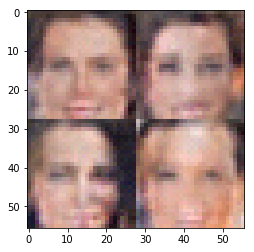

Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7810


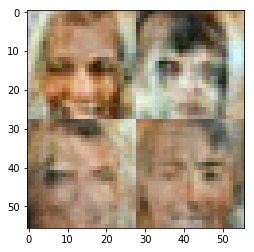

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7584


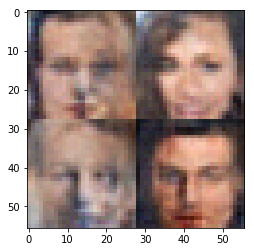

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7307


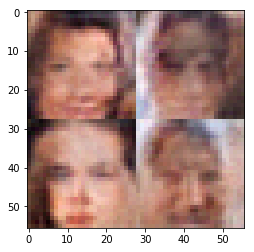

Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7284


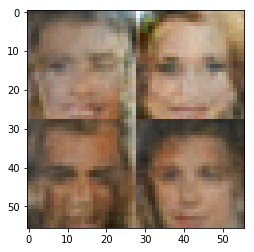

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8417


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.